In [1]:
!pip uninstall -y protobuf tensorflow keras
!pip install protobuf==3.20.3 tensorflow==2.15.0


Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: keras 3.10.0
Uninstalling keras-3.10.0:
  Successfully uninstalled keras-3.10.0
ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [2]:
!pip install -q tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 90.4 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.33.4 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow-text 2.19

In [3]:
import tensorflow as tf
print("TF version:", tf.__version__)


TF version: 2.20.0


**Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import re, string
import torch

from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split


**Load Dataset**

In [5]:
DATA_PATH = '/kaggle/input/jigsaw-toxic-comment-classification-challenge'

train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df  = pd.read_csv(f'{DATA_PATH}/test.csv')


In [6]:

train_df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Basic Dataset Info**

In [7]:
# Basic info
print("🔹 Train shape:", train_df.shape)
print("🔹 Test shape :", test_df.shape)

print("\n🔹 Train columns:")
print(train_df.columns)

print("\n🔹 Dataset info:")
train_df.info()

print("\n🔹 Missing values:")
print(train_df.isnull().sum())

print("\n🔹 Duplicate rows:", train_df.duplicated().sum())

print("\n🔹 Label distribution:")
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print(train_df[labels].sum())



🔹 Train shape: (159571, 8)
🔹 Test shape : (153164, 2)

🔹 Train columns:
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

🔹 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB

🔹 Missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: i

**Text Cleaning**

In [8]:
def clean_text(text):
    text = text.lower()
    
    # remove html
    text = re.sub(r'<.*?>', '', text)
    
    # remove url
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # remove numbers
    text = re.sub(r'\d+', '', text)
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


**EDA & Visualization**

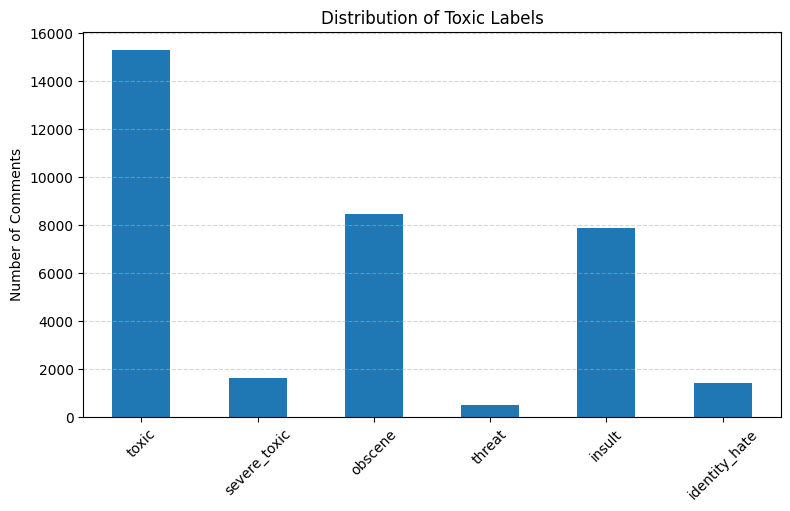

In [9]:
import matplotlib.pyplot as plt

labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

label_counts = train_df[labels].sum()

plt.figure(figsize=(9,5))
label_counts.plot(kind='bar')
plt.title("Distribution of Toxic Labels")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


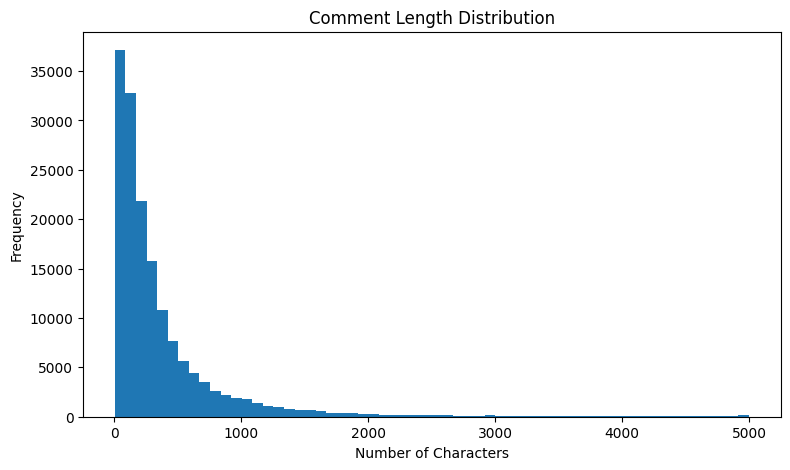

In [10]:
train_df['comment_length'] = train_df['comment_text'].apply(len)

plt.figure(figsize=(9,5))
plt.hist(train_df['comment_length'], bins=60)
plt.title("Comment Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


In [11]:
print(train_df.columns)


Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'comment_length'],
      dtype='object')


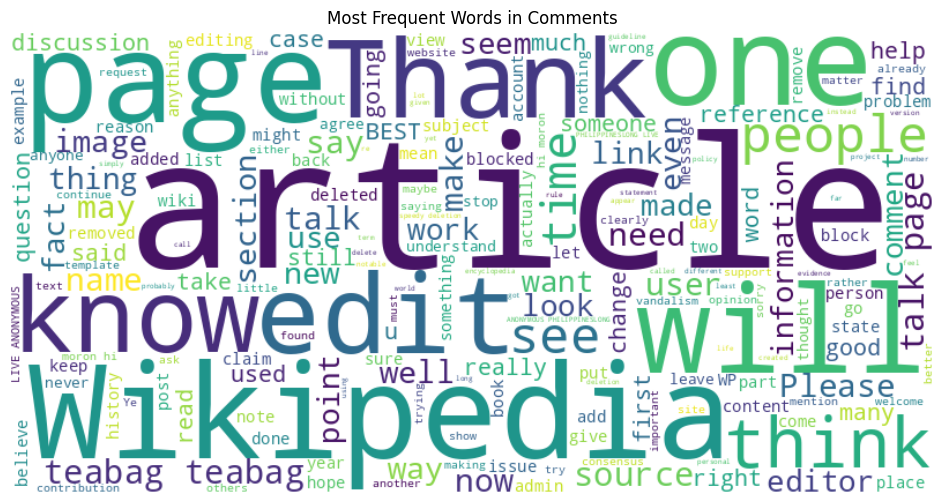

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(
    train_df['comment_text']
    .dropna()
    .astype(str)
    .sample(min(6000, len(train_df)))
)

wc = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Comments")
plt.show()


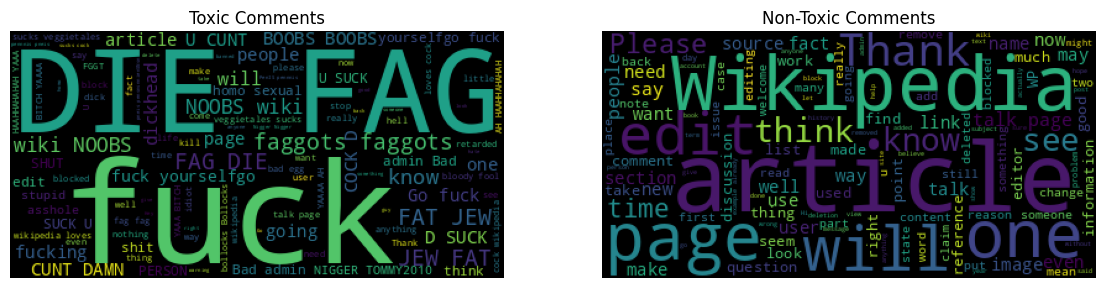

In [13]:
toxic_text = train_df[train_df['toxic'] == 1]['comment_text']
clean_texts = train_df[train_df['toxic'] == 0]['comment_text']

wc_toxic = WordCloud(background_color='black').generate(" ".join(toxic_text.sample(3000)))
wc_clean = WordCloud(background_color='black').generate(" ".join(clean_texts.sample(3000)))

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.imshow(wc_toxic)
plt.title("Toxic Comments")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_clean)
plt.title("Non-Toxic Comments")
plt.axis("off")

plt.show()


**Train–Val Split**

In [14]:
train_df['clean_comment'] = train_df['comment_text'].apply(clean_text)
test_df['clean_comment']  = test_df['comment_text'].apply(clean_text)


In [15]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

X = train_df['clean_comment']
y = train_df[labels].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)


**Tokenization (RoBERTa)**

In [16]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

X_train_tok = tokenize(X_train)
X_val_tok   = tokenize(X_val)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

**Dataset Class**

In [17]:
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item


**Dataset Creation**

In [18]:
train_dataset = ToxicDataset(X_train_tok, y_train)
val_dataset   = ToxicDataset(X_val_tok, y_val)


**DataLoader**

In [20]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8)


**Model Initialization**

In [21]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=6,
    problem_type="multi_label_classification"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

**Model Training**

In [22]:
from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 1   # VERY IMPORTANT

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", total_loss / len(train_loader))


100%|██████████| 17952/17952 [34:55<00:00,  8.57it/s]

Epoch 1 Loss: 0.05026877332316959


**Model Evaluation**

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        probs = torch.sigmoid(outputs.logits)
        preds = (probs > 0.3).int()

        all_preds.append(preds.cpu())
        all_labels.append(labels_batch.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_labels).numpy()

print("Shape y_true:", y_true.shape)
print("Shape y_pred:", y_pred.shape)


Shape y_true: (15958, 6)
Shape y_pred: (15958, 6)


In [25]:
label_names = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

print(
    classification_report(
        y_true,
        y_pred,
        target_names=label_names,
        zero_division=0
    )
)


               precision    recall  f1-score   support

        toxic       0.72      0.88      0.79      1480
 severe_toxic       0.31      0.86      0.46       148
      obscene       0.77      0.88      0.82       836
       threat       0.59      0.46      0.52        37
       insult       0.64      0.85      0.73       791
identity_hate       0.55      0.37      0.44       147

    micro avg       0.67      0.84      0.75      3439
    macro avg       0.59      0.72      0.62      3439
 weighted avg       0.69      0.84      0.75      3439
  samples avg       0.07      0.08      0.07      3439



**Visualization**

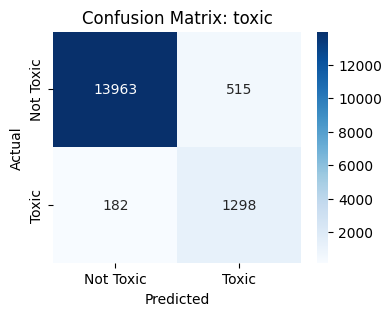

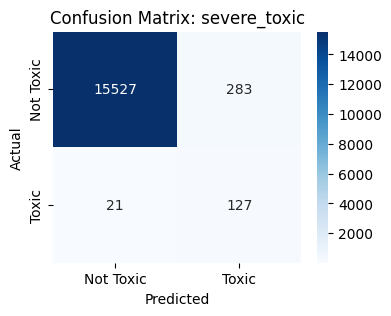

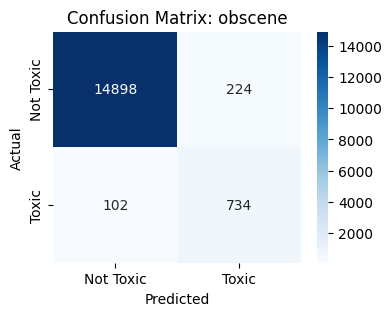

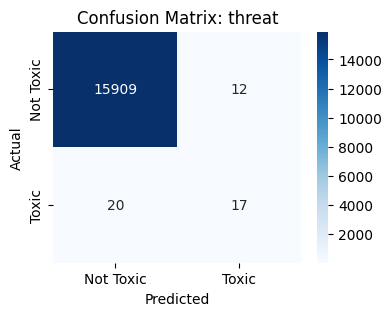

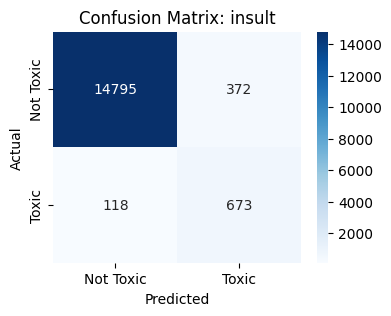

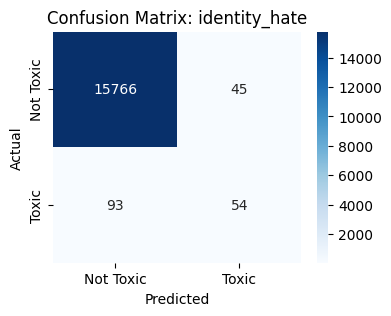

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

for i, label in enumerate(label_names):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])

    plt.figure(figsize=(4,3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Not Toxic", "Toxic"],
        yticklabels=["Not Toxic", "Toxic"]
    )
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



**Prediction Test**

In [27]:
test_tok = tokenize(test_df['comment_text'])

test_dataset = ToxicDataset(test_tok, np.zeros((len(test_df), 6)))
test_loader = DataLoader(test_dataset, batch_size=8)

test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        test_preds.append(torch.sigmoid(outputs.logits).cpu().numpy())

test_preds = np.vstack(test_preds)


<class 'numpy.ndarray'> (153164, 6)


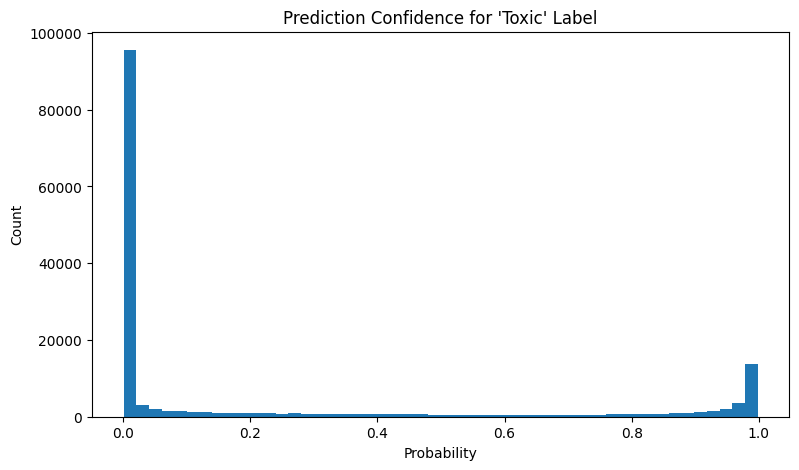

In [28]:
# test_preds is already numpy array
print(type(test_preds), test_preds.shape)

plt.figure(figsize=(9,5))
plt.hist(test_preds[:, 0], bins=50)
plt.title("Prediction Confidence for 'Toxic' Label")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()


In [29]:
print("y_val type:", type(y_val))
print("preds type:", type(preds))

if torch.is_tensor(y_val):
    print("y_val shape:", y_val.shape)
else:
    print("y_val len:", len(y_val))

if torch.is_tensor(preds):
    print("preds shape:", preds.shape)
elif isinstance(preds, list):
    print("preds len:", len(preds))
    print("first element shape:", np.array(preds[0]).shape)


y_val type: <class 'numpy.ndarray'>
preds type: <class 'torch.Tensor'>
y_val len: 15958
preds shape: torch.Size([6, 6])


In [30]:
model.eval()

all_preds = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        probs = torch.sigmoid(outputs.logits)   # (batch_size, 6)
        all_preds.append(probs.cpu())

# 🔥 MOST IMPORTANT LINE
preds = torch.cat(all_preds, dim=0)   # (15958, 6)

print("FINAL preds shape:", preds.shape)


FINAL preds shape: torch.Size([15958, 6])


In [31]:
from sklearn.metrics import roc_auc_score

roc_scores = []

for i, label in enumerate(labels):
    score = roc_auc_score(
        y_val[:, i],        # numpy
        preds[:, i].numpy() # torch → numpy
    )
    roc_scores.append(score)
    print(f"{label}: ROC-AUC = {score:.4f}")


tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'): ROC-AUC = 0.9835
tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'): ROC-AUC = 0.9911
tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'): ROC-AUC = 0.9909
tensor([1., 1., 1., 0., 1., 0.], device='cuda:0'): ROC-AUC = 0.9872
tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'): ROC-AUC = 0.9849


In [32]:
print(type(roc_scores))


<class 'list'>


In [34]:
import torch
import numpy as np

# --- fix labels ---
if isinstance(labels, torch.Tensor):
    labels = labels.detach().cpu().tolist()
else:
    labels = [str(l) for l in labels]

# --- fix roc_scores ---
def safe_float(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().item()
    elif isinstance(x, np.ndarray):
        return float(x)
    else:
        return float(x)

roc_scores = [safe_float(x) for x in roc_scores]

print("labels:", labels)
print("roc_scores:", roc_scores)
print("types:", type(labels[0]), type(roc_scores[0]))


labels: ['[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]', '[1.0, 1.0, 1.0, 0.0, 1.0, 0.0]', '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]']
roc_scores: [0.9834961852652486, 0.9911149289707164, 0.9909101350483374, 0.9872054077820048, 0.9848973047396382]
types: <class 'str'> <class 'float'>


In [37]:
import torch
import numpy as np

model.eval()

labels = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

def predict_toxicity(text, threshold=0.5):
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

    results = {labels[i]: float(probs[i]) for i in range(len(labels))}

    is_toxic = any(p > threshold for p in probs)

    return is_toxic, results


In [38]:
text = "You are a stupid idiot and nobody likes you"
toxic, scores = predict_toxicity(text)

print("Input Text:", text)
print("Toxic?:", "YES 🚨" if toxic else "NO ✅")
print("Scores:")
for k, v in scores.items():
    print(f"{k}: {v:.3f}")


Input Text: You are a stupid idiot and nobody likes you
Toxic?: YES 🚨
Scores:
toxic: 0.995
severe_toxic: 0.262
obscene: 0.846
threat: 0.008
insult: 0.953
identity_hate: 0.068


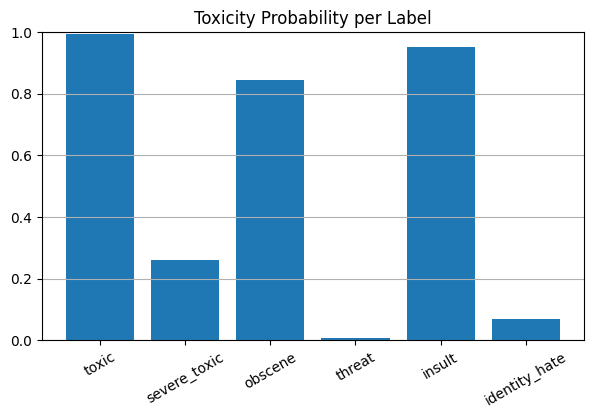

In [39]:
plt.figure(figsize=(7,4))
plt.bar(scores.keys(), scores.values())
plt.ylim(0,1)
plt.title("Toxicity Probability per Label")
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.show()
